# Classification of Cheese Firmness Model


# Introduction 

In this notebook, we will build a multi-class classification model for the `Cheese` dataset obtained from the Government of Canada's Open Government Portal [1](https://open.canada.ca/en).

## Question(s) of interests

Cheese comes in a variety of textures and firmnesses. Knowing the firmness of the cheese might make the consumer's life easier when selecting their next meal or preparing their charcuterie board. 

According to their degree of firmness, cheeses can be hard, firm, veined/blue, semi-soft, soft, or fresh [2](https://www.cheesescience.org/cheesetypes.html). The question is: How may cheese firmness be determined based on characteristics like moisture content, fat content, and milk treatment? Consumers, chefs, and cheese-making businesses, among other industries, can benefit from a cheese classification model.

## Dataset description 

The `cheese_df` dataset composed of $13$ tables contains various forms of information about various kinds of cheese. We will use characteristics that affect our choice of cheese firmness in the classification model and respond to the proposed question. Due to the importance of identifying the proper cheese texture, our target is the column `CategoryTypeEn` and we are interested in accurately recognizing all classes. `ManufacturerProvCode`, `ManufacturingTypeEn`, `MoisturePercent`, `Organic`, `MilkTypeEn`, `MilkTreatmentTypeEn`, `CheeseName`, and `FatLevel` are the features that affect cheese firmness.

In [1]:
# Import libraries needed
import string
import warnings

import altair as alt
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from scipy.stats import randint
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

warnings.simplefilter(action="ignore", category=FutureWarning)

# Exploratory Data Analysis

Reading the dataset will be the first step. We will use the entire `cheese df` for the exploratory analysis because we are working with a tiny dataset. In the following section, we will divide the data into the necessary train and test splits. 


In [2]:
# Importing data into the Jupyter notebook
cheese_df = pd.read_csv("cheese_data.csv")
cheese_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [3]:
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


Totalling 13 tables, the cheese dates have three numerical features and largely categorized information. There are 1042 observations in total, and certain features have null values. We will use SimpleImputer to fill in these values afterwards.

We will drop the following irrelevant features :

**CheeseId**: Unique ID. 

**FlavourEn**: The flavour of the cheese has no effect on firmness or texture.

**CharacteristicsEn**: Characteristics such as colour or shape have no impact on firmness or texture. 

**RindTypeEn**: The rind can help identify the cheese type. However, because the column contains 30% null values, we will simply drop the feature.
    

We will drop missing rows before proceeding because there aren't many missing values in the target column `CategoryTypeEn`. Our data frame now has 1019 observations and 8 features.  
    

In [4]:
# Dropping columns that do not contribute to the prediction.
cheese_df = cheese_df.drop(
    columns=["CheeseId", "FlavourEn", "RindTypeEn", "CharacteristicsEn"]
)
# Dropping rows where values in the target column are missing before proceeding.
cheese_df = cheese_df.dropna(subset=["CategoryTypeEn"])

In [5]:
cheese_df.describe()  # (include="all")

,MoisturePercent,Organic
count,1005.000000,1019.000000
mean,47.170050,0.096173
std,9.637901,0.294973
min,12.000000,0.000000
25%,40.000000,0.000000
50%,46.000000,0.000000
75%,52.000000,0.000000
max,92.000000,1.000000


Because `Organic` is a binary feature, we cannot really benefit from its statistics. We can clearly see the difference between the min and max values for `MoisturePercent` indicating that it will have an impact on identifying cheese firmness. The feature also has a high standard deviation, resulting in high variability from the mean.



According to the International Dairy Federation, moisture levels have the most influence on cheese firmness [3](https://www.fil-idf.org/wp-content/uploads/2021/02/Cheese-and-varieties-Part-2_-Cheese-styles-.pdf). As a result, we will use simple visualization to compare various features to the moisture level. We'll use a custom function that groups by a feature, calculates the mean of `MoisturePercent` and returns a bar plot in ascending order.

In [6]:
# Importing a custom made function for plotting
from feature_plot import feature_plot

feature_list = ["CategoryTypeEn", "FatLevel", "MilkTreatmentTypeEn"]
figure_dict = dict()
for feature in feature_list:
    figure_dict.update(
        {feature: feature_plot(cheese_df, feature, "MoisturePercent", "show")}
    )
figure_dict

Fresh Cheese in CategoryTypeEn have the highest avergae MoisturePercent of 60.375
Hard Cheese in CategoryTypeEn have the lowest avergae MoisturePercent of 34.21290322580645


alt.Chart(...)

lower fat in FatLevel have the highest avergae MoisturePercent of 50.677439024390246
higher fat in FatLevel have the lowest avergae MoisturePercent of 40.57736389684814


alt.Chart(...)

Pasteurized in MilkTreatmentTypeEn have the highest avergae MoisturePercent of 48.333333333333336
Raw Milk in MilkTreatmentTypeEn have the lowest avergae MoisturePercent of 41.59035087719298


alt.Chart(...)

{'CategoryTypeEn':      CategoryTypeEn  MoisturePercent
 1      Fresh Cheese        60.375000
 4       Soft Cheese        51.952852
 3  Semi-soft Cheese        46.983628
 5    Veined Cheeses        43.092000
 0       Firm Cheese        40.647093
 2       Hard Cheese        34.212903,
 'FatLevel':      FatLevel  MoisturePercent
 1   lower fat        50.677439
 0  higher fat        40.577364,
 'MilkTreatmentTypeEn':   MilkTreatmentTypeEn  MoisturePercent
 0         Pasteurized        48.333333
 2           Thermised        42.661290
 1            Raw Milk        41.590351}

The first visualization clearly shows that the target classes are not balanced based on distribution variations. The moisture content of hard and firm cheeses is extremely low. Fresh and soft have extremely high moisture levels. 

The second visualization shows the effect of fat on moisture levels. We can connect it to the first visualization and suggest that lower-fat cheeses will have higher moisture levels, resulting in softer cheeses, and vice versa. 

In the final visualization, the impact of milk treatment has little effect on moisture levels. As a result, it has little to no effect on the firmness of the cheese.


# Methods & Results 

The data will be split into 80% train and 20% test splits.


In [7]:
# Split the data into  80% train and 20% test datasets
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["CategoryTypeEn"]), train_df["CategoryTypeEn"]
X_test, y_test = test_df.drop(columns=["CategoryTypeEn"]), test_df["CategoryTypeEn"]
X_train

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
79,ON,Industrial,42.0,0,Cow,Pasteurized,Brick (Tre Stelle),lower fat
178,QC,Farmstead,46.0,0,Cow,Pasteurized,Cabouron (Le),lower fat
1020,NB,Farmstead,50.0,0,Goat,Pasteurized,Poivroux (Le),lower fat
432,QC,Industrial,50.0,0,Cow,Pasteurized,Brie Tour de France (Damafro),higher fat
757,ON,Industrial,76.0,0,Cow,Pasteurized,Ranchero Fresh Cheese,lower fat
...,...,...,...,...,...,...,...,...
1008,QC,Farmstead,45.0,0,Cow,Thermised,Religieuse,higher fat
323,QC,Industrial,55.0,0,Cow,Pasteurized,Feta (Anco),lower fat
383,QC,Industrial,49.0,0,Cow,Pasteurized,Chaliberg léger,lower fat
366,QC,Industrial,42.0,0,Goat,Pasteurized,Patte Blanche,lower fat


The next step is to separate numeric, categorical, binary, and text features. We will use **SimpleImputer** to replace any missing values in numeric features with the mean. **StandardScaler** will be used to standardize the features to unit variance. Using **SimpleImputer**, we will transform categorical and binary features to replace missing values with the most frequent values. We'll use **OneHotEncoder** on categorical features to ignore any unknown values and on binary features to remove one of the two columns because it's binary.

For text features, we'll use **FunctionTransformer** to squeeze the shape of the array before applying **CountVectorizer** and returning a multidimensional array. **CountVectorizer** will ignore terms that appear in more than 80% of the documents and terms that appear in less than 5 documents. Finally, we will create the **ColumnTransformer**, which will contain all of the features' transformers.


In [8]:
### Splitting numeric, categorical, binary, and text features in X_train
numeric_features = ["MoisturePercent", "Organic"]
categorical_features = [
    "ManufacturerProvCode",
    "ManufacturingTypeEn",
    "MilkTypeEn",
    "MilkTreatmentTypeEn",
]
binary_features = ["FatLevel"]
text_features = ["CheeseName"]
target_column = "CategoryTypeEn"

# Transformations on the numeric, categorical and binary features
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="if_binary", sparse=False, dtype=int),
)

text_transformer = make_pipeline(
    FunctionTransformer(lambda x: x.squeeze()),
    CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.80),
    FunctionTransformer(lambda x: x.toarray()),
)

# ColumnTransformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    (text_transformer, text_features),
    remainder="passthrough",
)

We will use DummyClassifier to create a baseline model to which the estimators will be compared. We will loop over the three strategies in order to maximize the baseline model results. 

In [9]:
# Looping over different strategies to find the best baseline DummyClassifier model
strategies = ["stratified", "most_frequent", "uniform"]

results_dict = {"strategies": [], "mean_train_score": [], "mean_cv_score": []}

for strategy in strategies:
    baseline_pipe = make_pipeline(preprocessor, DummyClassifier(strategy=strategy))
    scores = cross_validate(
        baseline_pipe, X_train, y_train, cv=10, return_train_score=True
    )
    results_dict["strategies"].append(strategy)
    results_dict["mean_cv_score"].append(scores["test_score"].mean())
    results_dict["mean_train_score"].append(scores["train_score"].mean())

results_dict = pd.DataFrame(results_dict)
results_dict

,strategies,mean_train_score,mean_cv_score
0,stratified,0.238444,0.245528
1,most_frequent,0.336197,0.336239
2,uniform,0.167827,0.159545


We will use the best baseline DummyClassifier model with the strategy 'most_frequent' because it had the highest training and validation scores.

In [10]:
# The best baseline DummyClassifier model with the strategy `most_frequent`
best_baseline = make_pipeline(preprocessor, DummyClassifier(strategy="most_frequent"))
baseline_scores = pd.DataFrame(
    cross_validate(best_baseline, X_train, y_train, cv=10, return_train_score=True)
)
# Fitting the baseline model on the train data and scoring on the test one
best_baseline.fit(X_train, y_train)
best_baseline.score(X_test, y_test)

0.36764705882352944

The cross-validation score is 0.336239 and the test score is 0.367647. By comparing the test score to the cross-validation results, we can conclude that the cross-validation scores were fairly representative. 



The following estimators will be put to the test: Logistic Regression, K-Nearest Neighbors, Support Vector Machines, Random Forest, and Decision Tree. For the initial comparison of our models, we will rely on the accuracy metric. We will balance data using the 'class_weight="balanced"' argument for all estimators because the classes in `CategoryTypeEn` are imbalanced. I've included all five kinds of supervised classification algorithms for studying purposes. 


In [11]:
# Testing different estimators and comparing on the accuracy scored by each model
results_dict = {
    "Dummy Classifier": {
        "mean_train_accuracy": round(baseline_scores["train_score"].mean(), 5),
        "mean_validation_accuracy": round(baseline_scores["test_score"].mean(), 5),
        "mean_fit_time (s)": round(baseline_scores["fit_time"].mean(), 5),
        "mean_score_time (s)": round(baseline_scores["score_time"].mean(), 5),
    }
}

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=500),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
}

for model_name, model in models.items():

    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(
        pipe, X_train, y_train, cv=10, return_train_score=True, n_jobs=-1
    )
    results_dict[model_name] = {
        "mean_train_accuracy": scores["train_score"].mean().round(5),
        "mean_validation_accuracy": scores["test_score"].mean().round(5),
        "mean_fit_time (s)": scores["fit_time"].mean().round(5),
        "mean_score_time (s)": scores["score_time"].mean().round(5),
    }

results_df = pd.DataFrame(results_dict).T
results_df

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
Dummy Classifier,0.33620,0.33624,0.01579,0.00644
Logistic Regression,0.69420,0.58406,0.09966,0.00990
kNN,0.69107,0.54476,0.01995,0.01426
RBF SVM,0.72665,0.60360,0.08498,0.02241
Decision Tree,0.95460,0.60604,0.02417,0.00651
Random Forest,0.95542,0.62811,0.22865,0.01690


We expected KNN to perform the worst because it classifies by simply voting for each point's k-nearest neighbours. Next, we see that logistic regression performs slightly better, but it has poor overall performance because it only works when the target is binary. We also know that RBF SVM is a more polished version of KNN. So we expected it to perform better; however, RBF SVM performs better in high-dimensional problems. Finally, we can see that the Decision tree and Random forest have comparable training accuracy, but the Random forest has a significantly higher cross-validation score. 
 

In [12]:
# Random Forest classifier scored the highest mean training and validation score
print(
    results_df["mean_train_accuracy"].max(),
    results_df["mean_validation_accuracy"].max(),
)

0.95542 0.62811


Using the best-performing estimator, we will use RandomizedSearchCV to tune the hyper-parameters 'n_estimators' and 'max_depth'. We chose RandomizedSearchCV because it eliminates unnecessary computation and tests a wide range of values.


We will use f1 weighted because we are dealing with a multi-class classification problem. Because precision and recall are trade-offs, we chose f1 as a great metric for minimizing both false positives and false negatives. We will use the **‘f1_weighted'** for scoring and refit since we're interested in the overall score rather than the score of a specific class.


In [13]:
# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    # "randomforestclassifier__min_samples_split": range(1,1000,10),
    "randomforestclassifier__n_estimators": range(1, 500),
    "randomforestclassifier__max_depth": range(1, 500),
}

scoring_dict = {"accuracy": "accuracy", "f1_weighted": "f1_weighted"}
main_pipe = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight="balanced", random_state=77)
)

depth_search = RandomizedSearchCV(
    main_pipe,
    param_grid,
    cv=10,
    return_train_score=True,
    n_iter=50,
    verbose=2,
    n_jobs=-1,
    scoring=scoring_dict,
    refit="f1_weighted",
    random_state=77,
)

depth_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent',
                                                                                'Organic']),
                                                          

In [14]:
# Best hyperparameters with the highest f1 weighted score
best_depth = depth_search.best_params_
best_depth_score = depth_search.best_score_
best_model = depth_search.best_estimator_

print(best_depth, best_depth_score)

{'randomforestclassifier__n_estimators': 336, 'randomforestclassifier__max_depth': 329} 0.6187974771994764


In [15]:
# Evaluation the best model on the training and test data
best_model.fit(X_train, y_train)
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(train_score, test_score)

0.9546012269938651 0.6372549019607843


Based on the above results, the model is overfitting. 

When the test score of 0.637254 and the cross-validation result of 0.6187974 are compared, the cross-validation score is fairly representative. 


We'll try to visualize the difference in f1 scores between training and validation scores.

In [16]:
# Cross validation results of each split
grid_results = (
    pd.DataFrame(depth_search.cv_results_)
    .loc[
        :,
        [
            "mean_train_f1_weighted",
            "mean_test_f1_weighted",
            "param_randomforestclassifier__max_depth",
            "param_randomforestclassifier__n_estimators",
        ],
    ]
    .sort_values(by="mean_train_f1_weighted", ascending=False)
)
grid_results.head()

,mean_train_f1_weighted,mean_test_f1_weighted,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators
35,0.956297,0.608169,35,115
36,0.956134,0.611393,254,86
19,0.956128,0.611384,328,64
37,0.956116,0.610957,156,65
27,0.955984,0.608864,104,61


In [17]:
# Unpivot grid_results from wide to long format for plotting
plotting_source = grid_results.melt(
    id_vars=[
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__n_estimators",
    ],
    value_vars=["mean_train_f1_weighted", "mean_test_f1_weighted"],
    var_name="score_type",
    value_name="f1_weighted",
)
plotting_source

,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,score_type,f1_weighted
0,35,115,mean_train_f1_weighted,0.956297
1,254,86,mean_train_f1_weighted,0.956134
2,328,64,mean_train_f1_weighted,0.956128
3,156,65,mean_train_f1_weighted,0.956116
4,104,61,mean_train_f1_weighted,0.955984
...,...,...,...,...
95,217,30,mean_test_f1_weighted,0.606097
96,224,27,mean_test_f1_weighted,0.605353
97,88,27,mean_test_f1_weighted,0.605353
98,339,11,mean_test_f1_weighted,0.602873


In [18]:
# Visualizing the change of f1 training and validation score
depth_search_plot = (
    alt.Chart(plotting_source, width=500, height=300)
    .mark_line()
    .encode(
        alt.X(
            "param_randomforestclassifier__max_depth:Q",
            axis=alt.Axis(title="Tree Depth"),
        ),
        alt.Y("f1_weighted:Q"),
        alt.Color(
            "score_type:N",
            scale=alt.Scale(
                domain=["mean_train_f1_weighted", "mean_test_f1_weighted"],
                range=["pink", "red"],
            ),
        ),
    )
    .properties(
        title=("Comparing the means of train and validation scores of f1_weighted")
    )
)
depth_search_plot

alt.Chart(...)

We can see that both scores are harmonious with a slight increase between 300 and 350. The graph is consistent with our best parameters results.


Next, we will show the confusion matrix and the classification report.


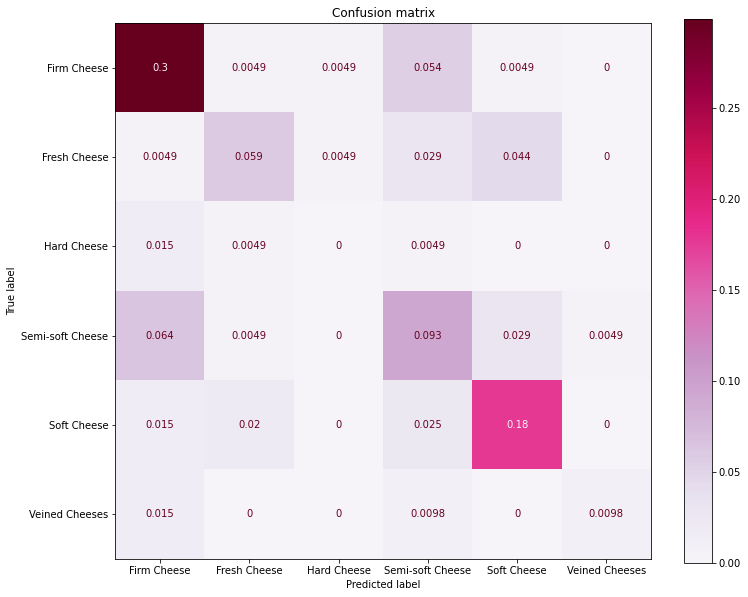

In [19]:
# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
plot_confusion_matrix(depth_search, X_test, y_test, ax=ax, normalize="all", cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

In [20]:
# Printing classification report
print(classification_report(y_test, depth_search.predict(X_test), digits=5))

                  precision    recall  f1-score   support

     Firm Cheese    0.72619   0.81333   0.76730        75
    Fresh Cheese    0.63158   0.41379   0.50000        29
     Hard Cheese    0.00000   0.00000   0.00000         5
Semi-soft Cheese    0.43182   0.47500   0.45238        40
     Soft Cheese    0.69231   0.75000   0.72000        48
  Veined Cheeses    0.66667   0.28571   0.40000         7

        accuracy                        0.63725       204
       macro avg    0.52476   0.45631   0.47328       204
    weighted avg    0.62721   0.63725   0.62501       204



From the classification report, we noticed that the class `Hard Cheese` metrics are all zero. We suspected such behaviour due to its very low number of occurrences (which is 5).  

Based on the classification report, the accuracy is 0.63725, the precision weighted average is 0.62721, the recall weighted average is 0.63725 and the f1-score weighted average is 0.62501. When the Random forest model and the baseline model's accuracy were compared, the Random forest model scored 30% higher. The `MoisturePercent` and `FatLevel` features both contributed significantly to the high accuracy and f1_weighted scores.


# Discussion 

In this notebook, we used multiple estimators to determine which one worked best for our multi-class classification problem. The Random forest model with the highest accuracy of 0.95569 on the training set and 0.61828 on the validation set was chosen. Using RandomizedSearchCV, we found the best parameters `n_estimators` and `max_depth`. We scored 0.954601 on the training set, 0.618797 on the validation set, and 0.637254 on the test set using the metric f1_weighted. When we compare our results to the baseline model, which scored 0.367647 on the test set, we see a nearly 30% improvement.
 
Considering that we were working with a limited set of data, the overall results were as expected. The model could be improved by increasing the data size to allow for enough observations for each class. One of the model's main limitations is that it lacks critical features for determining cheese firmness, such as fat percentage and temperature [4](https://doi.org/10.1155/2016/8690380). Because of the influence of fat on moisture level, the model could be greatly improved if we had the exact percentage of fat. Data on the storage temperature would also help in determining cheese firmness. In order to get more precise results, we must therefore ask another question: What treatments were used to produce each type of cheese? Pasteurized, for example, is mostly used to make fresh and soft cheese, whereas thermalized is mostly used to make firm cheese.

# References 


* 1. [The Government of Canada's Open Government Portal((provided by UBC, ExL)](https://open.canada.ca/en)
 
* 2. [Cheese Science Toolkit](https://www.cheesescience.org/cheesetypes.html)

* 3. [International Dairy Federation](https://www.fil-idf.org/wp-content/uploads/2021/02/Cheese-and-varieties-Part-2_-Cheese-styles-.pdf)

* 4. [Yuanrong Zheng, Zhenmin Liu, Beihong Mo, "Texture Profile Analysis of Sliced Cheese in relation to Chemical Composition and Storage Temperature", Journal of Chemistry, vol. 2016, Article ID 8690380, 10 pages, 2016.](https://doi.org/10.1155/2016/8690380)
   